In [1]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict,OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import glob
import os
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression
from scipy.stats import entropy
import string
import datetime
import numpy as np
from joblib import Parallel, delayed
from time import sleep
from utils import *
from sklearn.mixture import BayesianGaussianMixture
import scipy.stats as stats
import importlib
import utils
import warnings
from itertools import combinations

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)
import networkx as nx

import leidenalg
import igraph as ig

# importlib.reload(utils)


In [2]:
groups = {
    'ExCo': ['ceo', 'cto', 'cfo', 'coo', 'cmo', 'cio', 'cso', 'cpo', 'cco', 'cro', 'svp', 'evp', 'cdo', 'cbo', 'cxo'],
    'Founder': ['founder'],
    'Engineering': ['software engineer', 'data scientist'],
    'Leadership': ['president', 'managing director', 'director', 'vp', 'chairman', 'executive director', 'general manager', 'vp engineering'],
    'Board': ['board member', 'member board director', 'board directors', 'chairman board', 'advisory board member', 'board observer'],
    'Ownership': ['owner', 'partner', 'managing partner', 'founding partner'],
    'Investor':['investor'],
    'Advisory': ['advisor', 'consultant'],
    'Other': ['member', 'team member', 'associate', 'product manager', 'principal']
}

dimension_labels = list(groups.keys())

colors = sns.color_palette(
                            "tab10", 
                            n_colors=len(dimension_labels)
                          )

## Loading data

In [3]:
df_org          = pd.read_csv('../data/organizations.csv')
df_jobs         = pd.read_csv('../data/jobs.csv')
df_people       = pd.read_csv('../data/people.csv')
df_fund_rounds  = pd.read_csv('../data/funding_rounds.csv')
df_ipos         = pd.read_csv('../data/ipos.csv')
df_acquisitions = pd.read_csv('../data/acquisitions.csv')
df_jobs_cleaned = pd.read_csv('../data/jobs_cleaned.csv',
                              converters={'group': str_to_list})

df_org_foundation = df_org[['uuid', 'founded_on','country_code','city','total_funding_usd']]
# Convert the 'founded_on' column to datetime
df_org_foundation['founded_on'] = pd.to_datetime(df_org_foundation['founded_on'], errors='coerce')
# Drop rows with NaN values (including out-of-bounds datetime)
df_org_foundation = df_org_foundation[df_org_foundation['founded_on'].notna()]
df_org_foundation = df_org_foundation[df_org_foundation['country_code'].notna()]


### Creating the dendogram

In [4]:
# ---- Parameters ---- #
start_year = 2010  # Define the start year for filtering organizations and jobs
end_year = start_year + 1  # Define the end year for filtering (one year range)

# Filter the organizations and jobs based on the specified year range
df_org_filtered = filter_by_year_range(df_org_foundation, 'founded_on', start_year, end_year)
df_jobs_filtered = filter_by_year_range(df_jobs_cleaned, 'started_on', start_year, end_year)

# Define the minimum counts for cities and jobs to be included in the analysis
minimum_city_count = 100
minimum_jobs_count = 100

# ---- Filtering ----- #

# Count the occurrences of each city in the filtered organization DataFrame
city_counts = df_org_filtered['city'].value_counts()

# Filter the cities to include only those with counts greater than or equal to the minimum_city_count
filtered_city_counts = city_counts[city_counts >= minimum_city_count]

# Filter the organization DataFrame to include only the cities that meet the minimum count criteria
df_org_filtered = df_org_filtered[df_org_filtered.city.isin(filtered_city_counts.index.tolist())]

# Merge the filtered organization and jobs DataFrames on the organization UUID
df_merge = pd.merge(df_org_filtered, df_jobs_filtered, left_on='uuid', right_on='org_uuid')

# Explode the 'group' column into separate rows, one for each group associated with an organization
exploded = df_merge.explode('group').reset_index(drop=True)

# Count the occurrences of unique elements, grouped by 'city' and 'group'
group_counts = exploded.groupby(['city', 'group']).size().reset_index(name='count')

# Pivot the data to have the groups as columns, with cities as the index and counts as values
pivoted = group_counts.pivot(index='city', columns='group', values='count').fillna(0)

# Calculate the total number of groups for each city
city_totals = pivoted.sum(axis=1)

# Filter the pivoted DataFrame to include only cities with a total group count greater than or equal to the minimum count
filtered_pivoted = pivoted[city_totals >= minimum_jobs_count]

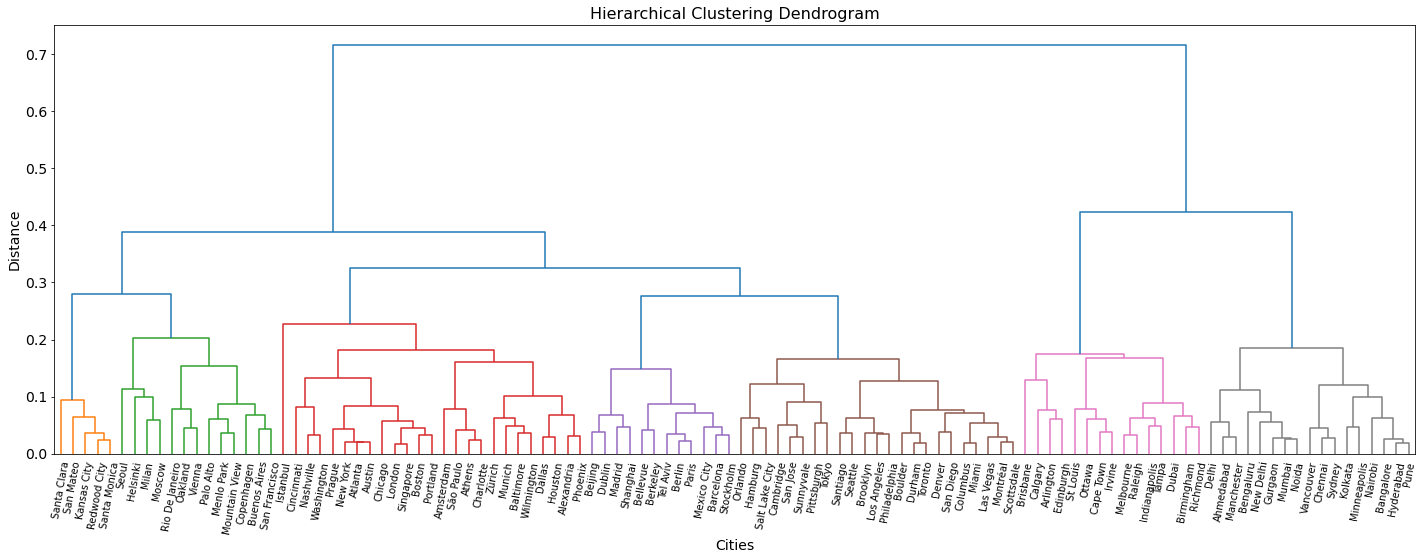

In [5]:
normalized_pivoted = filtered_pivoted.apply(lambda row: row / row.sum(), axis=1)
Z = linkage(normalized_pivoted, method='ward')
createDendogram(normalized_pivoted,Z,threshold = 0.25)

### Show the fingerprints per cluster

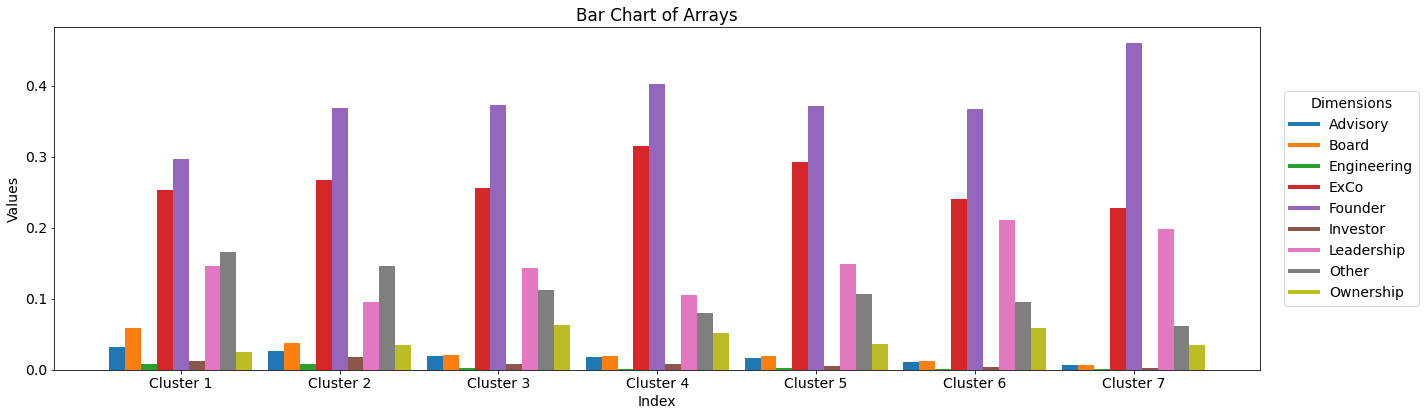

In [6]:
cluster_cities = plotClusters(filtered_pivoted,
              list(filtered_pivoted.columns),
              sns.color_palette("tab10", n_colors=len(filtered_pivoted.columns)),
              Z,
              normalized=True, 
              difference=False,
              clusters = 7,
              return_cities=True
            )       

## Network Fingerprints

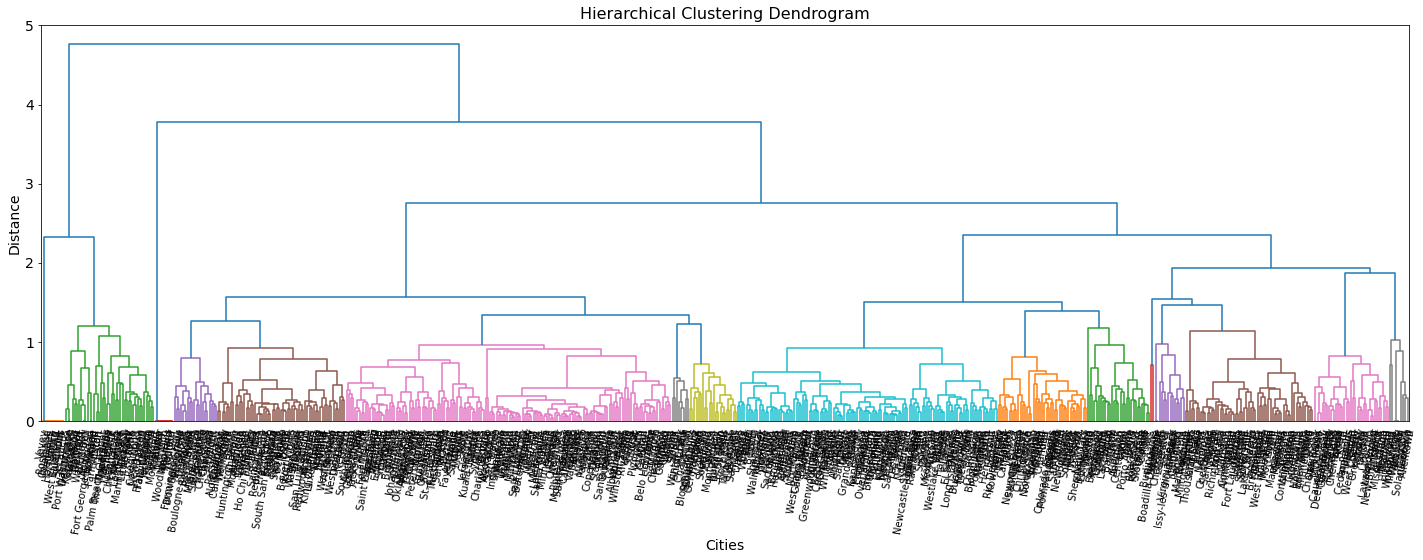

/Users/vc/Research/caratterizzazione-sistemi-innovativi/utils.py:250: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


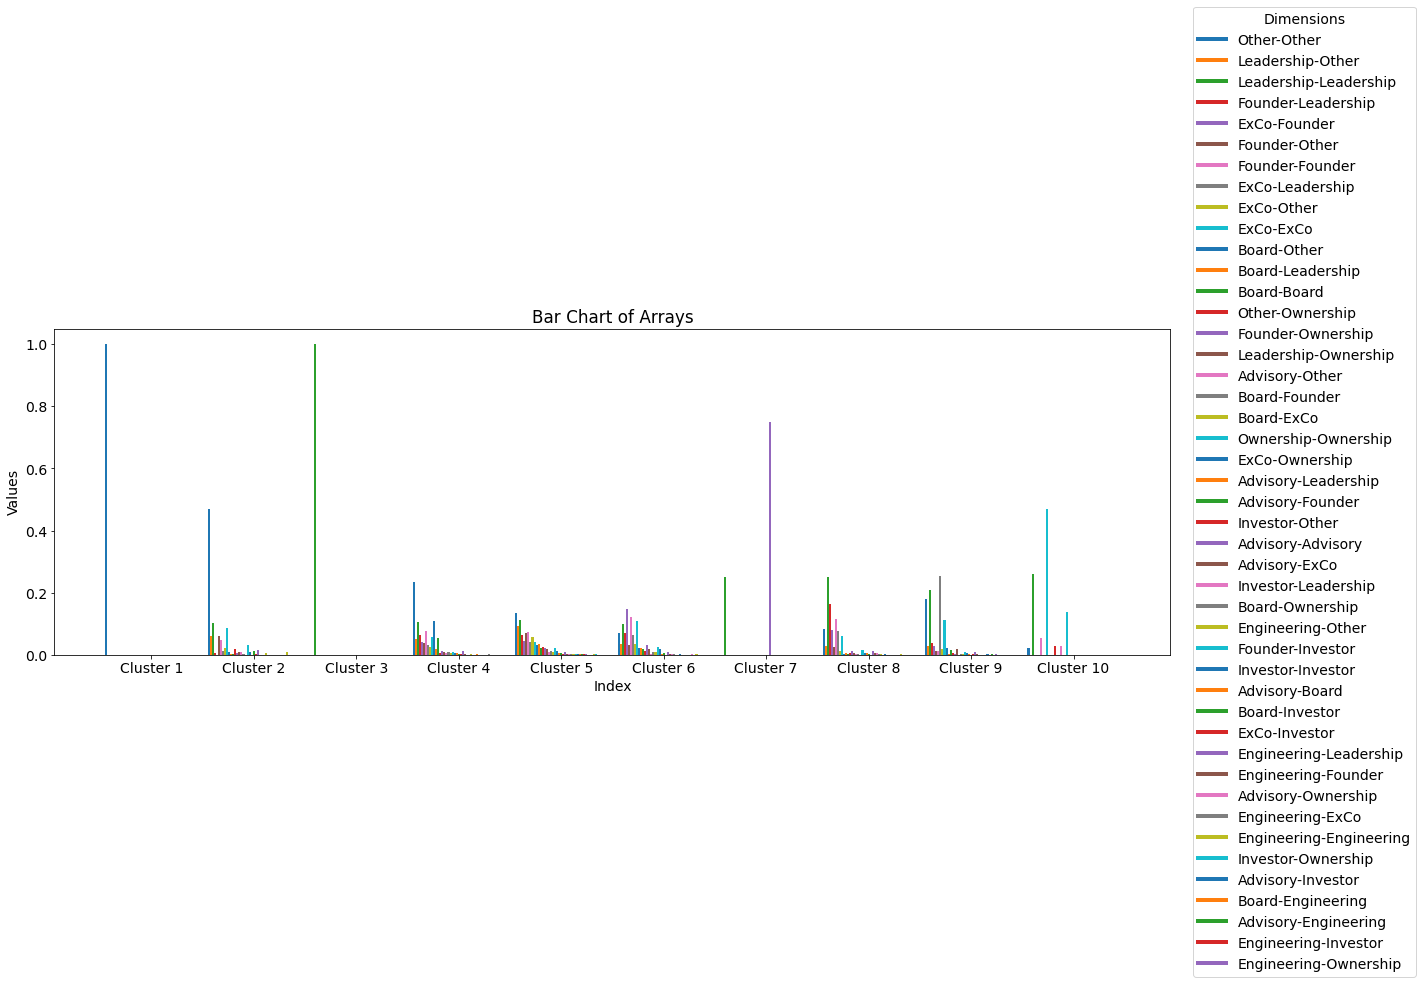

In [7]:
year = 2010
categories = ['-'.join(sorted(i)) for i in list(combinations(list(groups.keys()),2))]
categories.extend([i+'-'+i for i in list(groups.keys())])
categories = sorted(categories)

# df = networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider='New York')

network_df = networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider='all')
Z = linkage(network_df, method='ward')
createDendogram(network_df,Z,threshold = 1.2)

cluster_cities = plotClusters(network_df,
              list(network_df.columns),
              sns.color_palette("tab10", n_colors=len(network_df.columns)),
              Z,
              normalized=True, 
              difference=False,
              bar_width = 0.02,
              clusters = 10,
              return_cities=True
              )       

## Entropy and city trend

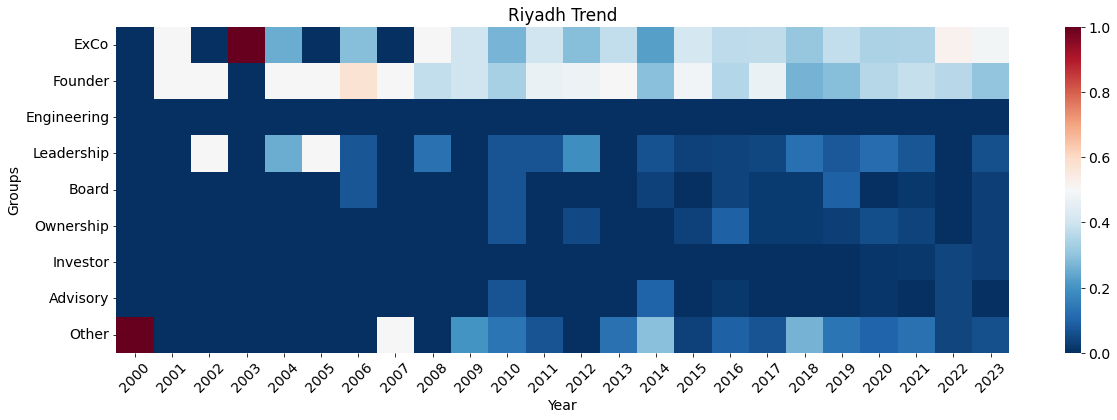

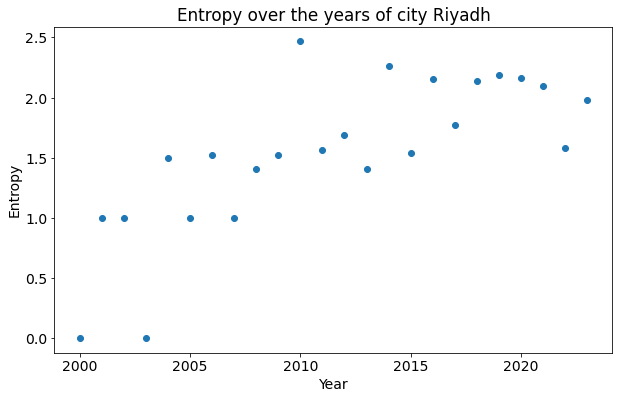

In [8]:
city = 'Riyadh'
start_year = 2000
end_year = 2024

matrix = np.zeros((end_year-start_year,len(dimension_labels)))

# List of unique groups (dimension labels)
unique_groups = dimension_labels

# -------

# Iterate through each year from 2000 to 2023
for year_index, year in enumerate(range(start_year, end_year)):
    tmp_end_year = year  # Set the end year to the start year (single year filtering)
    
    # Filter organizational data by the year range
    df_org_filtered = filter_by_year_range(df_org_foundation, 'founded_on', year, tmp_end_year)
    
    # Filter job data by the year range
    df_jobs_filtered = filter_by_year_range(df_jobs_cleaned, 'started_on', year, tmp_end_year)

    # Merge filtered organization and job data on organization UUIDs
    df_merge = pd.merge(df_org_filtered[df_org_filtered.city == city], df_jobs_filtered, left_on='uuid', right_on='org_uuid')

    # Explode the 'groups' column into separate rows
    exploded = df_merge.explode('group').reset_index(drop=True)

    # Count occurrences of unique elements grouped by 'city' and 'group'
    group_counts = exploded.groupby(['city', 'group']).size().reset_index(name='count')

    # Normalize the group counts by the total counts within the city
    if not group_counts.empty:
        group_counts['normalized_count'] = group_counts['count'] / group_counts['count'].sum()

        # Assign counts to the appropriate position in the matrix
        for i, group in enumerate(unique_groups):
            if group in group_counts['group'].values:
                matrix[year_index, i] = group_counts[group_counts['group'] == group]['normalized_count'].values[0]

# Transpose the matrix for better visualization
transposed_matrix = matrix.T

# Create a DataFrame from the transposed matrix with years as columns and unique groups as rows
heatmap_data = pd.DataFrame(transposed_matrix, columns=range(start_year, end_year), index=unique_groups)

# Calculate entropy for each group of counts in the matrix
entropies = [entropy(group_counts, base=2) for group_counts in matrix]

heatmapPlot(heatmap_data,city)
entropyPlot(entropies,city)

In [9]:
l_coeff, city_coeff = entropyTrend(filtered_pivoted, 2000, 2024, df_jobs_cleaned, df_org_foundation)

/Users/vc/miniforge3/envs/atomico/lib/python3.8/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [10]:
dict(sorted(city_coeff.items(), key=lambda x: x[1]))

{'Beijing': -0.030850448692564512,
 'Sunnyvale': -0.02505523999117782,
 'Kolkata': -0.02379346837333907,
 'Baltimore': -0.022222859356388926,
 'Bellevue': -0.02074339188727472,
 'St Louis': -0.020457195031923833,
 'Rio De Janeiro': -0.020342371575835596,
 'Ottawa': -0.01888805081843345,
 'San Francisco': -0.01815999881704951,
 'Redwood City': -0.017418741190853074,
 'Santa Monica': -0.017122331645597826,
 'San Jose': -0.017020516780140885,
 'San Mateo': -0.016731480922744863,
 'Minneapolis': -0.015998530359618405,
 'Indianapolis': -0.01387090045183126,
 'Portland': -0.013860493069850995,
 'Stockholm': -0.013594127798762347,
 'Mountain View': -0.01255024141219121,
 'Hamburg': -0.01193653039339505,
 'Phoenix': -0.010896016147749056,
 'Alexandria': -0.010876058067653757,
 'Kansas City': -0.010844990590511902,
 'Dublin': -0.010566451019713086,
 'Chennai': -0.009951703538333974,
 'Birmingham': -0.009345159447447864,
 'Manchester': -0.008991984592363627,
 'Calgary': -0.008883817606404287,
 '

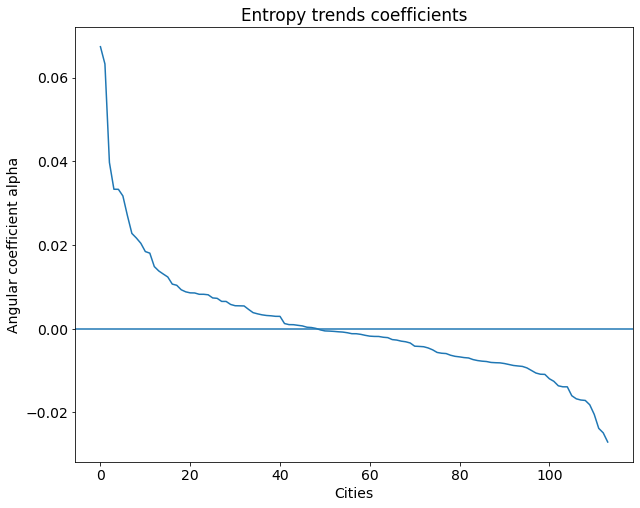

In [14]:
entropyTrendPlot(l_coeff)

## Network fingerprints trend analysis

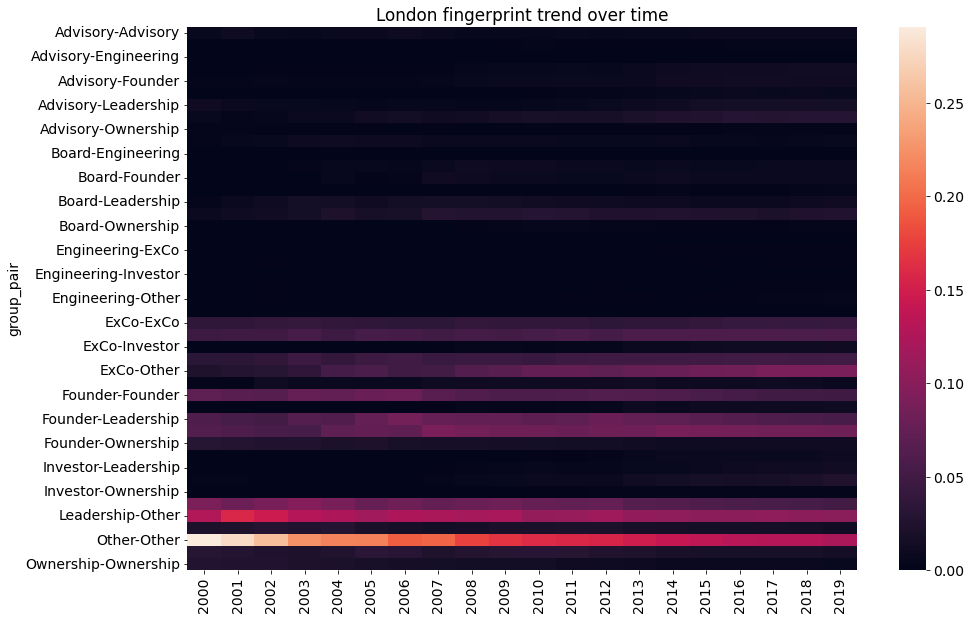

In [11]:
start_year = 2000
end_year   = 2020
city = 'London'

df = pd.concat([networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider=city) for year in range(start_year,end_year)])
df_2 = df.reindex(categories, axis=1, fill_value=0)
df_2 = df_2.fillna(0)
df_2.index = [i for i in range(start_year,end_year)]


plt.figure(figsize=(15,10))
plt.title(city+' fingerprint trend over time')
sns.heatmap(df_2.T);

In [21]:
entropy_dict = defaultdict(list)
angular_coeff_dict = defaultdict(float)

In [ ]:
for city in list(filtered_pivoted.index.tolist()):
    # if city in list(angular_coeff_dict.keys()):
    #     continue
    try:
        df = pd.concat([networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider=city) for year in range(start_year,end_year)])
        df_2 = df.reindex(categories, axis=1, fill_value=0)
        df_2 = df_2.fillna(0)
        df_2.index = [i for i in range(start_year,end_year)]
    except:
        print(city+', not enough startups')
        continue
    df_3 = df_2.reset_index(drop=True)
    df_3['Entropy'] = df_3.apply(calculate_entropy, axis=1)
    entropies = df_3['Entropy'].tolist()
    entropy_dict[city] = entropies
    angular_coeff_dict[city] = calculate_angular_coeff(entropies)
    print(city,calculate_angular_coeff(entropies))

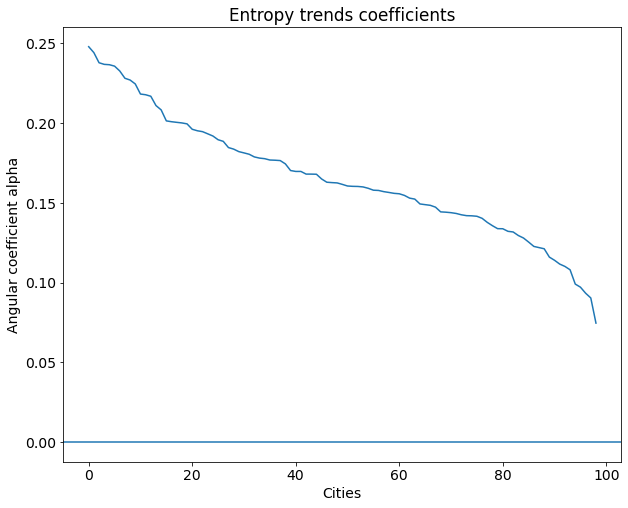

In [23]:
entropyTrendPlot(sorted(list(angular_coeff_dict.values())))

In [24]:
angular_coeff_dict

defaultdict(float,
            {'Ahmedabad': 0.11015999823063863,
             'Amsterdam': 0.22818499111838908,
             'Athens': 0.1337848490763665,
             'Atlanta': 0.14847684736264205,
             'Austin': 0.16973152914883977,
             'Bangalore': 0.18961980196363803,
             'Barcelona': 0.2327497286060508,
             'Bengaluru': 0.18052120578536518,
             'Berkeley': 0.11598961664658698,
             'Berlin': 0.24798572241580288,
             'Birmingham': 0.13384068703113697,
             'Boca Raton': 0.11161698616366367,
             'Boston': 0.16060219041341023,
             'Boulder': 0.23578337610839165,
             'Brooklyn': 0.174470692620223,
             'Brussels': 0.15706237801016873,
             'Buenos Aires': 0.22461125752909936,
             'Calgary': 0.16272267578469937,
             'Cambridge': 0.16805272083899803,
             'Charlotte': 0.14254179057314653,
             'Chennai': 0.15797210370664166,
             'Ch

# Acquisition analysis

In [191]:
year = 2015

fund_rounds = df_fund_rounds[['raised_amount_usd','announced_on','org_uuid']].dropna()
funding_df = filter_up_to_year(fund_rounds,'announced_on',year)

df_org_foundation = df_org_foundation.rename(columns={'uuid':'org_uuid'})
org_foundation = filter_up_to_year(df_org_foundation,'founded_on',year)

acquisition_df = df_acquisitions[['acquiree_uuid','acquiree_city','acquired_on','price_usd']].rename(columns={'acquiree_uuid':'org_uuid',
                                                                                                              'acquiree_city':'city'}).dropna()
acquisition_filtered = filterYear(acquisition_df,'acquired_on',year,delta=5)


In [192]:
df1 = pd.DataFrame(pd.merge(funding_df,org_foundation).groupby('city')['raised_amount_usd'].sum()).reset_index()
df2 = acquisition_filtered.groupby('city')['price_usd'].sum().reset_index()

In [193]:
df_merge = pd.merge(df1,df2)

Text(0, 0.5, 'Acquisition value')

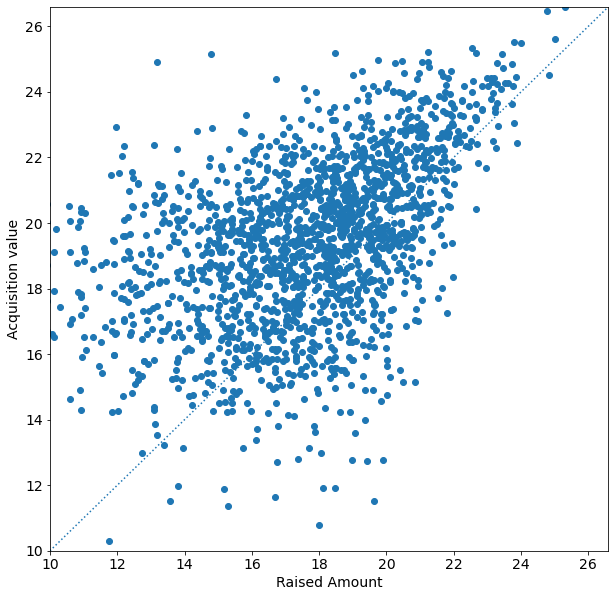

In [194]:
max_v = max(np.log(df_merge['price_usd']).max(),np.log(df_merge['raised_amount_usd']).max())
plt.figure(figsize=(10,10))
plt.xlim([10,max_v])
plt.ylim([10,max_v])
plt.scatter(np.log(df_merge['price_usd']),np.log(df_merge['raised_amount_usd']))
plt.plot([10,max_v],[10,max_v],':')
plt.xlabel('Acquisition value')
plt.ylabel('Raised Amount')

In [195]:
# import hdbscan
# # Create the HDBSCAN clustering
# clusterer = hdbscan.HDBSCAN(metric='euclidean', cluster_selection_method='eom')
# cluster_labels = clusterer.fit_predict(network_df)

# # Print the cluster labels
# print("Cluster labels:", cluster_labels)

# # Plot the dendrogram
# clusterer.condensed_tree_.plot(select_clusters=True)
# plt.title("Dendrogram")
# plt.show()


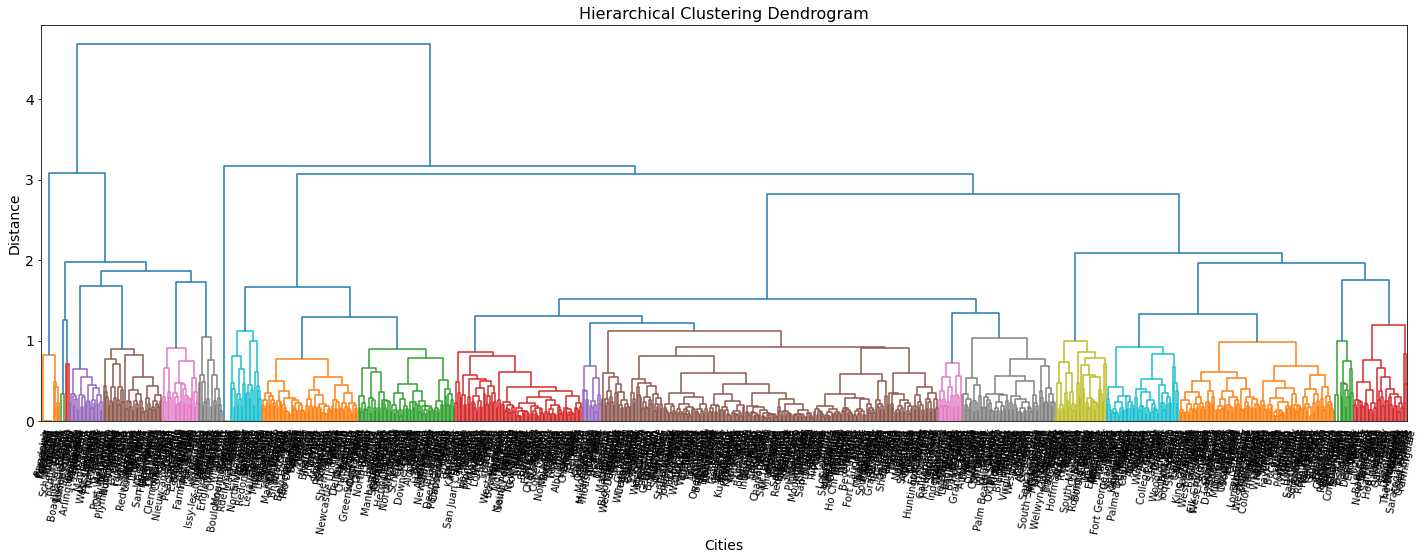

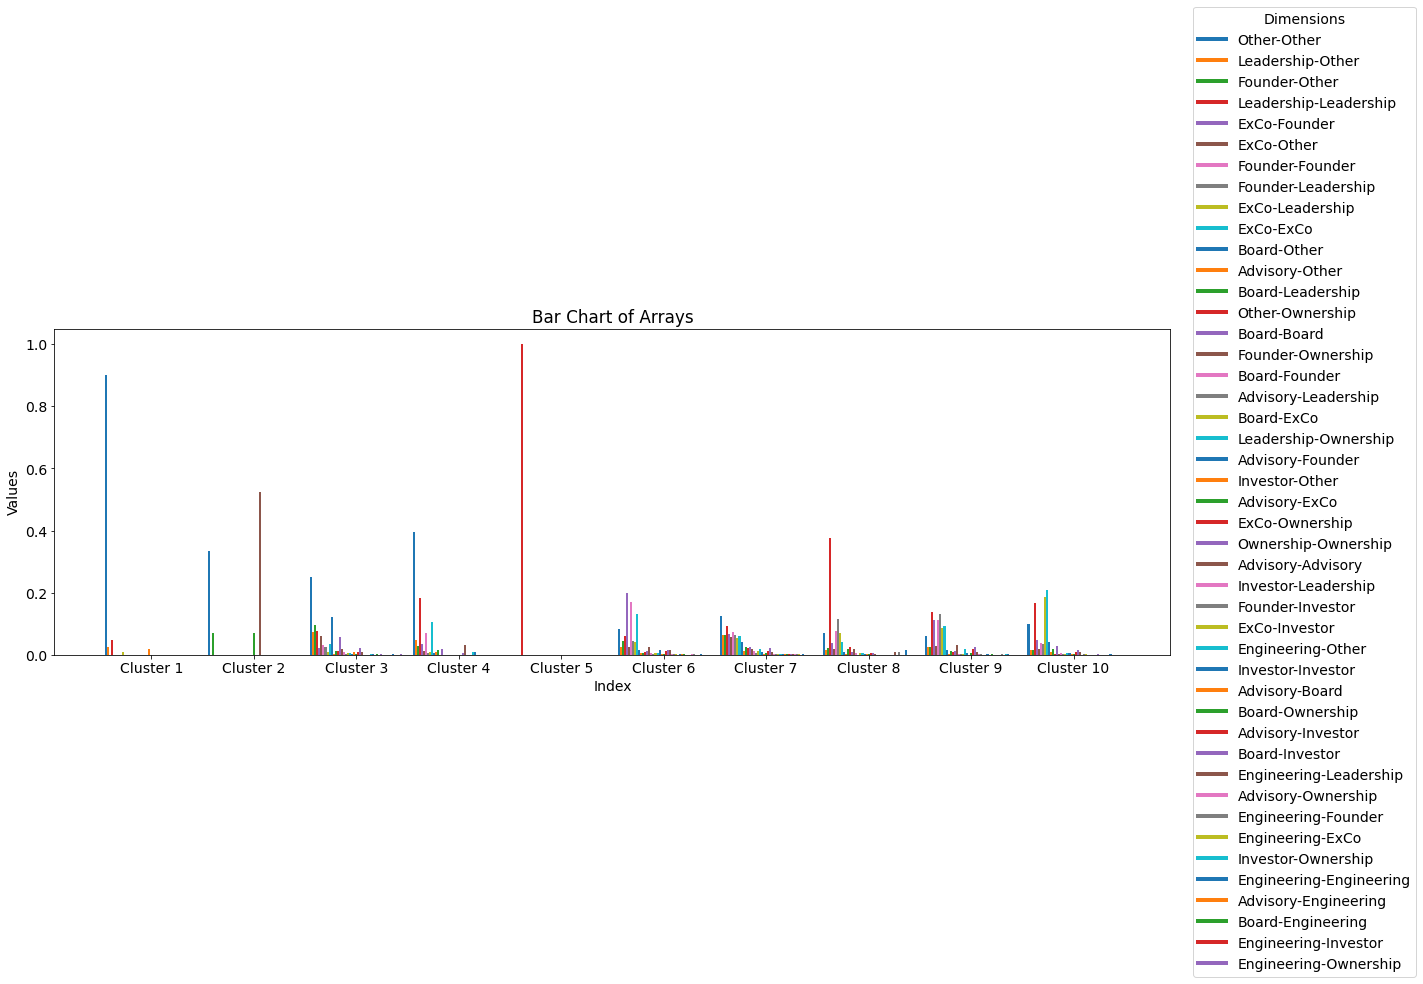

In [199]:
categories = ['-'.join(sorted(i)) for i in list(combinations(list(groups.keys()),2))]
categories.extend([i+'-'+i for i in list(groups.keys())])
categories = sorted(categories)

df = networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider='New York')

network_df = networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider='all')
Z = linkage(network_df, method='ward')
createDendogram(network_df,Z,threshold = 1.2)

cluster_cities = plotClusters(network_df,
              list(network_df.columns),
              sns.color_palette("tab10", n_colors=len(network_df.columns)),
              Z,
              normalized=True, 
              difference=False,
              bar_width = 0.02,
              clusters = 10,
              return_cities=True
              )    

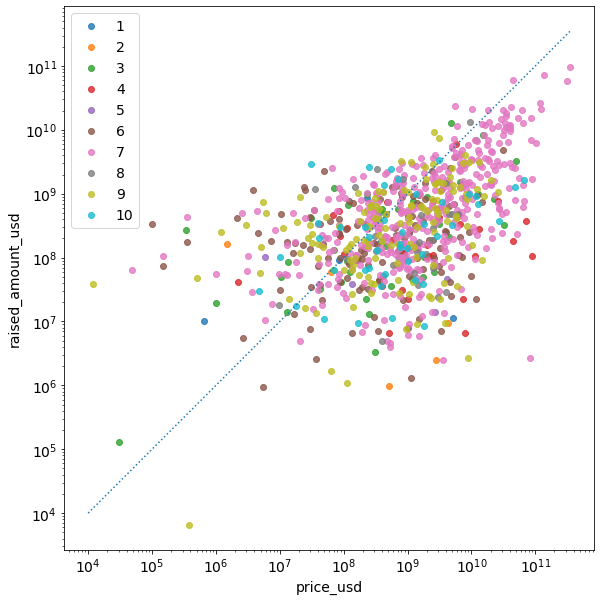

In [197]:
# Create a dictionary to map colors to keys
colors = {key: f"C{i}" for i, key in enumerate(cluster_cities.keys())}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))  # Square figure

# Plot the scatter plot
for key, city_list in cluster_cities.items():
    mask = df_merge['city'].isin(city_list)
    ax.scatter(df_merge.loc[mask, 'price_usd'], 
               df_merge.loc[mask, 'raised_amount_usd'], 
               color=colors[key], 
               label=key, 
               alpha=0.8)

# Set log scale for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('price_usd')
ax.set_ylabel('raised_amount_usd')

# Set aspect ratio to 1 (square)
ax.set_aspect('equal', adjustable='box')
max_v = max(df_merge['raised_amount_usd'].max(),df_merge['price_usd'].max())

plt.plot([1E4,max_v],[1E4,max_v],':')


# Add legend
ax.legend()

# Show the plot
plt.show()

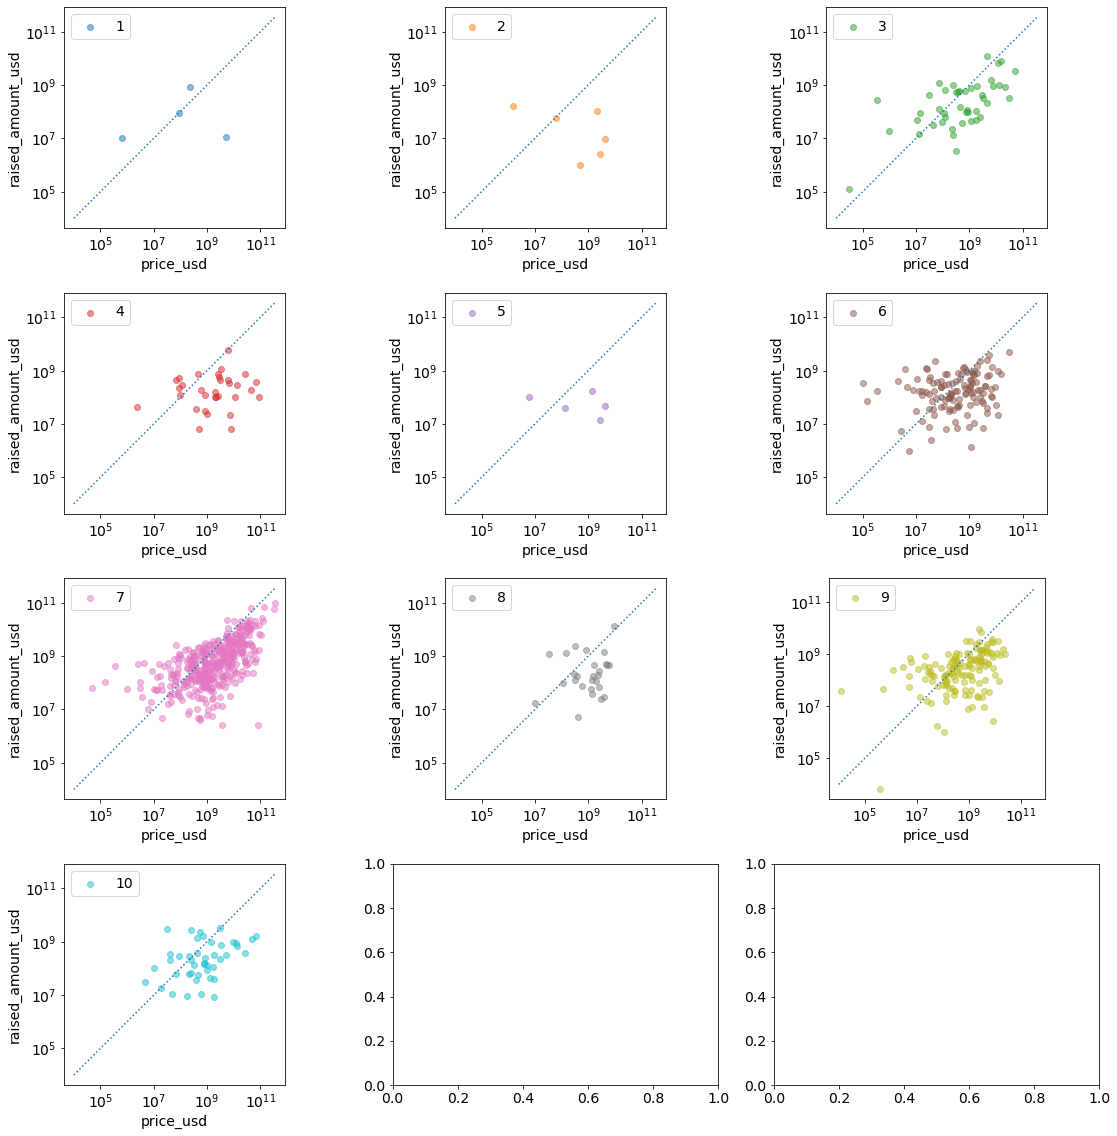

In [198]:
# Create a dictionary to map colors to keys
colors = {key: f"C{i}" for i, key in enumerate(cluster_cities.keys())}

# Calculate the number of rows and columns needed for the subplots
num_subplots = len(cluster_cities)
nrows = ceil(num_subplots ** 0.5)  # Square root of num_subplots, rounded up
ncols = ceil(num_subplots / nrows)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16), squeeze=False)

# Iterate over the subplots and keys
for ax, (key, city_list) in zip(axes.flat, cluster_cities.items()):
    # Filter the dataframe for the current key
    mask = df_merge['city'].isin(city_list)

    # Plot the scatter plot on the current subplot
    ax.scatter(df_merge.loc[mask, 'price_usd'], df_merge.loc[mask, 'raised_amount_usd'], color=colors[key], label=key, alpha=0.5)

    # Set log scale for both axes
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set axis labels
    ax.set_xlabel('price_usd')
    ax.set_ylabel('raised_amount_usd')

    # Set aspect ratio to 1 (square)
    ax.set_aspect('equal', adjustable='box')

    # Plot the bisectrice
 
    max_v = max(df_merge['raised_amount_usd'].max(),df_merge['price_usd'].max())

    ax.plot([1E4,max_v],[1E4,max_v],':')


    # Add legend
    ax.legend()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()
# Show the plot
plt.show()

## Diversification vs Specialization

In [4]:
org_categories = df_org[['uuid', 'founded_on','country_code','category_list','category_groups_list','city']]
org_categories['founded_on'] = pd.to_datetime(org_categories['founded_on'], errors='coerce')
org_categories.dropna(subset = ['founded_on', 'category_groups_list', 'category_list','city'], inplace=True)

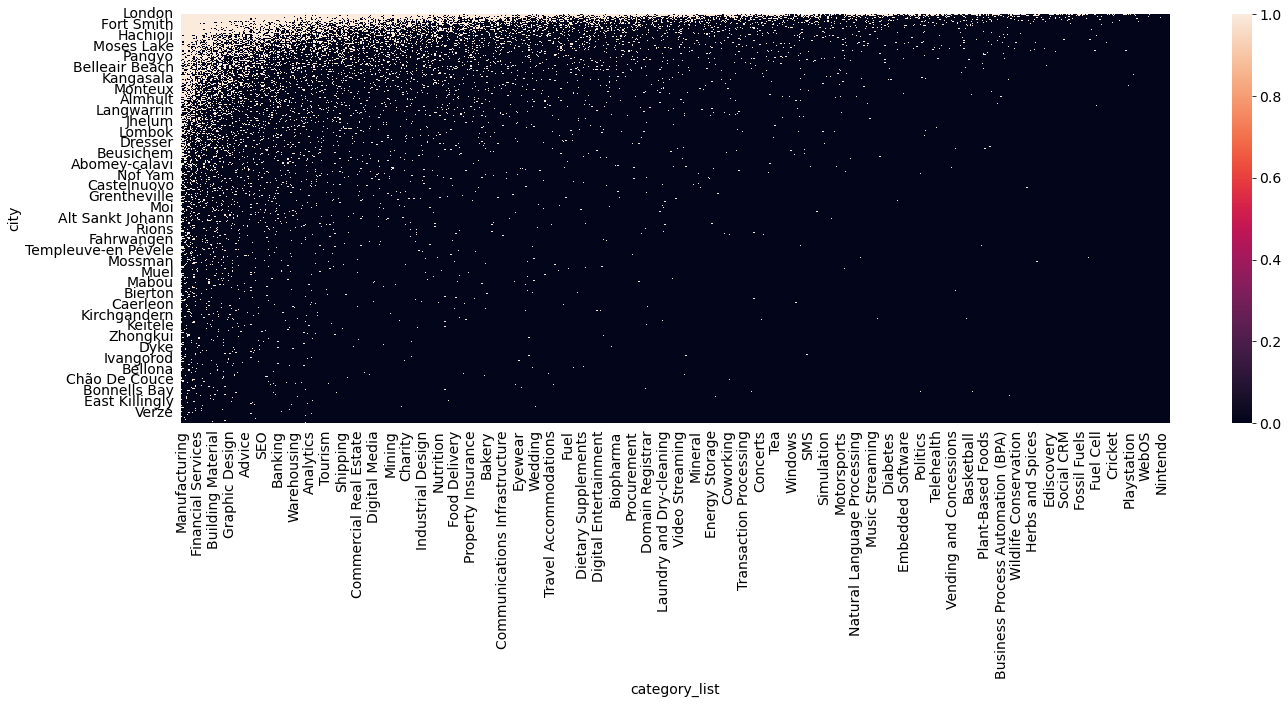

In [5]:
year = 2022
feature = 'category_list'
df = org_categories.dropna(subset=['country_code'])
org_filtered = filter_up_to_year(df,'founded_on',year)[['city',feature]]
org_filtered[feature] = org_filtered[feature].apply(lambda x: x.split(','))
df = org_filtered.explode(feature).reset_index(drop=True)


matrix = pd.crosstab(df['city'], df[feature])
# Fill missing values with 0
matrix = matrix.fillna(0)

matrix[matrix >= 1] = 1

# Sort the rows and columns
sorted_rows = matrix.sum(axis=1).sort_values(ascending=False).index
sorted_cols = matrix.sum(axis=0).sort_values(ascending=False).index
# Create the heatmap
M = matrix.loc[sorted_rows, sorted_cols].values
cities_M = matrix.loc[sorted_rows, sorted_cols].index
categories_M = matrix.loc[sorted_rows, sorted_cols].columns

plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(matrix.loc[sorted_rows, sorted_cols])
heatmap.tick_params(left=False, bottom=False)

# Adjust the layout
# heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()

In [6]:
import scipy.sparse as sp

# Convert the adjacency matrix to a sparse matrix
graph = M @ M.T
np.fill_diagonal(graph, 0)

graph[graph >= 1] = 1

AttributeError: module 'networkx' has no attribute 'from_numpy_matrix'

In [8]:
# Convert the column projection matrix to a graph
G = nx.from_numpy_array(graph)

# Get the number of connected components in the row projection graph
num_connected_components = nx.number_connected_components(G)

print(f"Number of connected components: {num_connected_components}")

: 

In [ ]:
from scipy.sparse.csgraph import connected_components


### Calculating the fitness and complexity

In [246]:
# Create a dictionary from the two arrays
fitness = {'city': cities_M, 'fitness': f}
complexity = {'category': categories_M, 'complexity': q}
# Create a DataFrame
df_fitness = pd.DataFrame(fitness)
df_complexity = pd.DataFrame(complexity)
# Sort the DataFrame by 'value' in descending order
df_fitness = df_fitness.sort_values(by='fitness', ascending=False)
df_complexity = df_complexity.sort_values(by='complexity', ascending=False)

In [144]:
# Define matrix M
M = np.array([[1, 1, 1, 0],
              [1, 0, 1, 0],
              [0, 1, 0, 1]])

# Initialize vector F with 3 elements equal to one
F0 = np.ones(3)
# Initialize vector Q with 4 elements equal to one
Q0 = np.ones(4)

max_iterations = 1000
toll = 1e-4
Qold = Q0
Fold = F0
for i in range(max_iterations):

    # Matrix multiplication of M transpose and F inverse
    Qnew = 1 / ( M.T @ (1 / Fold) )
    #print("\nResult of M multiplied by Q:\n", Q1)

    # Matrix multiplication of M and Q (possible size mismatch)
    Fnew = M @ Qold
    #print("\nResult of M multiplied by Q:\n", F1)

    # normalization
    Qnew = Qnew / np.mean(Qnew)
    Fnew = Fnew / np.mean(Fnew)

    distance = np.sum(np.abs(Qnew - Qold))

    if distance < toll:
        print(f"\nConverged in {i} steps")
        break
    Qold = Qnew
    Fold = Fnew

print(distance)
print("\nQ after normalization:\n", Qnew)
print("\nF after normalization:\n", Fnew)


Converged in 65 steps
9.507922513785072e-05

Q after normalization:
 [0.40016204 0.80010694 0.40016204 2.39956897]

F after normalization:
 [0.85728959 0.42869654 1.71401387]


# Markets Analysis NOT REVISED!!

In [7]:
def create_category_list_graph(df,is_list=True):
    G = nx.Graph()
    edge_counts = {}
    for row in df.itertuples(index=False):
        if is_list:
            categories = row.category_list.split(',')
        else:
            categories = row.category_groups_list.split(',')
        for cat1, cat2 in zip(categories, categories[1:]):
            cat1 = cat1.strip()
            cat2 = cat2.strip()
            edge = tuple(sorted([cat1, cat2]))
            edge_counts[edge] = edge_counts.get(edge, 0) + 1
            G.add_edge(cat1, cat2, weight=edge_counts[edge])
    for node in G.nodes:
        G.nodes[node]['label'] = node 
    return G

## Community analysis

In [30]:
# start_year = 2020
# end_year = 2021
networks = defaultdict()
# communities_dict = defaultdict()
for year in range(2000,2024):

    df_org_filtered = filter_by_year_range(org_categories,'founded_on',year,year+1)
    # print(len(df_org_filtered))

    category_graph = create_category_list_graph(df_org_filtered,is_list=True)
    mapping = {label: label for label in nx.get_node_attributes(category_graph, 'label').values()}
    integer_mapping = {i:label for i, label in enumerate(sorted(set(mapping.values())))}
    category_graph = nx.convert_node_labels_to_integers(category_graph,ordering='sorted',label_attribute='label')

    igraph_category_graph = networkx_to_igraph(category_graph)

    # Run the Leiden algorithm
    partition = leidenalg.find_partition(igraph_category_graph, 
                                        leidenalg.ModularityVertexPartition, 
                                        weights='weight')

    # print(f"Number of communities: {len(partition)}")

    # Map communities to nodes
    communities = {}
    for idx, community in enumerate(partition):
        for node in community:
            communities[igraph_category_graph.vs[node]['name']] = idx

    # Assign community to nodes in NetworkX graph
    community_mapping = {}
    for community_id, community in enumerate(partition):
        for node in community:
            community_mapping[integer_mapping[igraph_category_graph.vs[node]['name']]] = community_id

    G = nx.relabel_nodes(category_graph, integer_mapping)
    nx.set_node_attributes(G, community_mapping, 'community')

    networks[str(year)]= G

    # Save the graph in GEXF format
    nx.write_gexf(G, 'output_graph/category_graph_'+str(year)+'.gexf')

    # for community in partition:
    #     print(f"Community: {[igraph_category_graph.vs[i]['name'] for i in community]}")

In [31]:
G2 = networks['2001']
G1 = networks['2000']

# Find the edges present in G1 but not in G2
edges_in_G1_not_in_G2 = set(G1.edges) - set(G2.edges)
# print(f"Edges present in G1 but not in G2: {edges_in_G1_not_in_G2}")
print(len(edges_in_G1_not_in_G2))

# Find the edges present in G2 but not in G1
edges_in_G2_not_in_G1 = set(G2.edges) - set(G1.edges)
# print(f"Edges present in G2 but not in G1: {edges_in_G2_not_in_G1}")
print(len(edges_in_G2_not_in_G1))

8816
8219


In [33]:
merged_G = merge_graphs(G1,G2)

edges_to_remove = set(G1.edges)
merged_G.remove_edges_from(edges_to_remove)

nx.write_gexf(merged_G, 'output_graph/diff_G.gexf')
